# Augmented batch Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Implementation](#implementation)
3. [Evaluation](#evaluation)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

In [2]:
# Check TF versions and CPU/GPU availability
print(tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_gpu_available)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.19.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_gpu_available at 0x7f0eb5daccc0>
True
True
Num CPUs Available:  1
Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd
!ls

/content
drive  sample_data


In [5]:
import os
os.chdir("/content/drive/My Drive/Untrained-PINN-for-SIM-main")
print(os.getcwd())

/content/drive/My Drive/Untrained-PINN-for-SIM-main


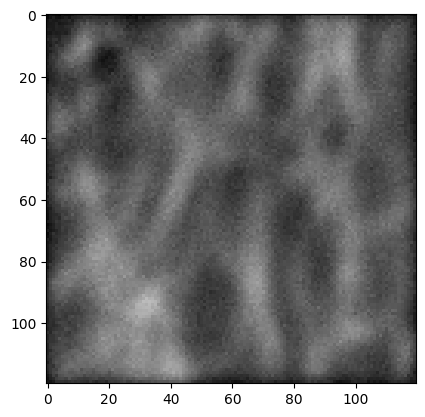

In [6]:
import cv2#show first picture of folder as image in notebook
img = cv2.imread('Data/LPSIM/microtubules/input_frames/1_1.png')
plt.imshow(img)

## Model Choice

This approach of an augmented batch model was based on the publication notebook PINN_demo_plasmonic_SIM.


## Implementation



In [7]:
num_im = 50      # Number of examples in dataset
frames = 24       # Number of sub-frames per example
im_dim = 480     # Image dimension (after super-res)
bg_lvl = 0       # Optional bg level subtraction

input_frames = np.zeros([num_im,im_dim,im_dim,frames])
gt_frames = np.zeros([num_im,im_dim,im_dim,1])
lr_frames = np.zeros([num_im,im_dim,im_dim,1])
patterns = np.zeros([frames,im_dim,im_dim,1])

## Load Data

In [8]:
data_name = 'microtubules'
dir_name = 'Data/LPSIM/'

for i in range(1,num_im):
      
    for j in range(1,(frames+1)):
       
        input_path = dir_name+data_name+'/input_frames/'+str(i)+'_'+str(j)+'.png'
        input_temp = cv2.imread(input_path,0)
        input_temp = cv2.resize(input_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
        input_frames[i-1,:,:,j-1] = input_temp                  
    
    gt_path = dir_name+data_name+'/ground_truth/'+str(i)+'.png'
    gt_temp = cv2.imread(gt_path,0)
    gt_temp = cv2.resize(gt_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    gt_temp = gt_temp.reshape([im_dim,im_dim,1])
    gt_frames[i-1,:,:,:] = gt_temp

    lr_path = dir_name+data_name+'/low_res/'+str(i)+'.png'
    lr_temp = cv2.imread(lr_path,0)
    lr_temp = cv2.resize(lr_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    lr_temp = lr_temp.reshape([im_dim,im_dim,1])
    lr_frames[i-1,:,:,:] = lr_temp
    

for i in range(1,(frames+1)):
    
    pattern_path = dir_name+data_name+'/patterns/'+str(i)+'.png'
    pattern_temp = cv2.imread(pattern_path,0)
    pattern = cv2.resize(pattern_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)  
    pattern = pattern.reshape([im_dim,im_dim,1])
    patterns[i-1,:,:,:] = pattern
            

## Check and Normalize Data

In [9]:
print(np.amax(input_frames))
input_frames = input_frames - bg_lvl;
input_frames[input_frames<0] = 0
input_frames = input_frames/np.amax(input_frames)
print(np.amax(input_frames))
gt_frames = gt_frames/np.amax(gt_frames)
lr_frames = lr_frames/np.amax(lr_frames)
patterns = patterns/np.amax(patterns)
print(input_frames.shape)
print(gt_frames.shape)

255.0
1.0
(50, 480, 480, 24)
(50, 480, 480, 1)


Text(0.5, 1.0, 'Illumination pattern')

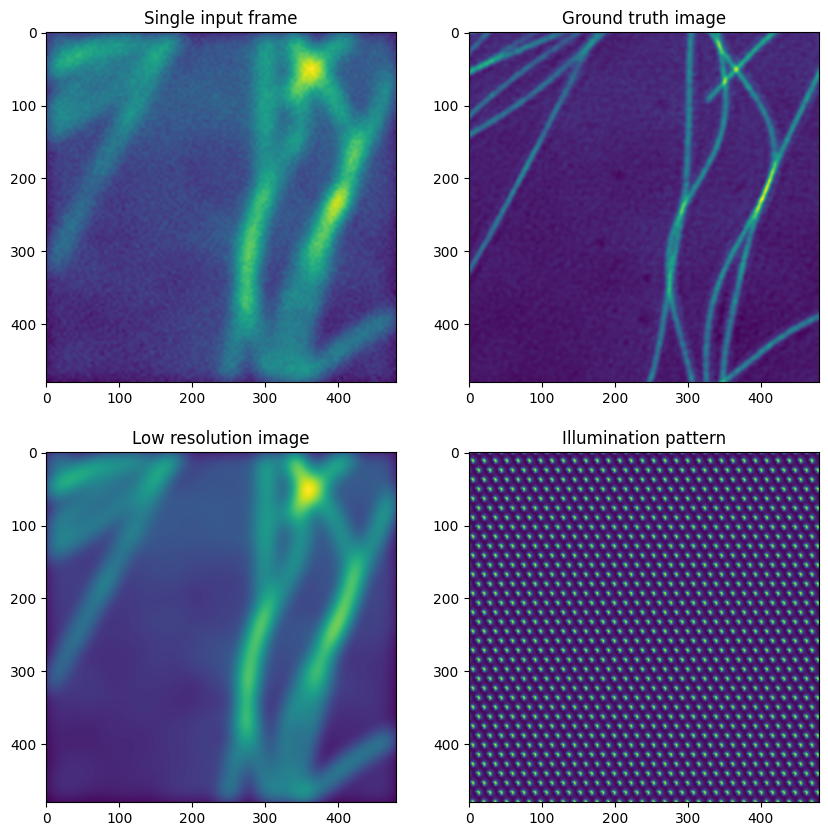

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(input_frames[1,:,:,1])
plt.title('Single input frame')
plt.subplot(2,2,2)
plt.imshow(gt_frames[1,:,:,:])
plt.title('Ground truth image')
plt.subplot(2,2,3)
plt.imshow(lr_frames[1,:,:,:])
plt.title('Low resolution image')
plt.subplot(2,2,4)
plt.imshow(patterns[1,:,:,:])
plt.title('Illumination pattern')

## Define Model

In [11]:
BATCH_SIZE = 8 # Define batch size

# Select a range for the batch

start_idx = 0
if start_idx + BATCH_SIZE > num_im:
    start_idx = num_im - BATCH_SIZE

# Create empty lists to store augmented data
x_batch_augmented = []
y_batch_augmented = []

# Define data augmentation function
def augment_data_pair(lr_img, gt_img):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        lr_img = tf.image.flip_left_right(lr_img)
        gt_img = tf.image.flip_left_right(gt_img)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        lr_img = tf.image.flip_up_down(lr_img)
        gt_img = tf.image.flip_up_down(gt_img)

    # Random 90-degree rotation
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    lr_img = tf.image.rot90(lr_img, k=k)
    gt_img = tf.image.rot90(gt_img, k=k)

    return lr_img, gt_img

# Loop through the selected range of images and apply augmentation
for i in range(start_idx, start_idx + BATCH_SIZE):
    # Convert NumPy arrays to TensorFlow tensors
    current_lr = tf.convert_to_tensor(lr_frames[i, :, :, :], dtype=tf.float32)
    current_gt = tf.convert_to_tensor(gt_frames[i, :, :, :], dtype=tf.float32)

    # Apply augmentation
    augmented_lr, augmented_gt = augment_data_pair(current_lr, current_gt)

    # Convert augmented TensorFlow tensors back to NumPy and append
    x_batch_augmented.append(augmented_lr.numpy())
    y_batch_augmented.append(augmented_gt.numpy())

# Convert lists to NumPy arrays
x_batch_augmented = np.array(x_batch_augmented)
y_batch_augmented = np.array(y_batch_augmented)

# Ensure final shapes
x_batch_augmented = x_batch_augmented.reshape((BATCH_SIZE, im_dim, im_dim, 1))
y_batch_augmented = y_batch_augmented.reshape((BATCH_SIZE, im_dim, im_dim, 1))

print(f"Shape of x_batch_augmented (augmented low-res batch): {x_batch_augmented.shape}")
print(f"Shape of y_batch_augmented (augmented ground truth batch): {y_batch_augmented.shape}")

Shape of x_batch_augmented (augmented low-res batch): (8, 480, 480, 1)
Shape of y_batch_augmented (augmented ground truth batch): (8, 480, 480, 1)


In [12]:
# Define U-Net model

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

k_size = 3

def u_net():

    inputs = Input((im_dim,im_dim,1)) # Input for supervised learning is a single LR frame
    block1 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(inputs)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block1)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block2)
    down1 = MaxPooling2D(pool_size=(2,2))(block2)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(down1)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block3)
    down2 = MaxPooling2D(pool_size=(2,2))(block3)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(down2)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block4)
    down3 = MaxPooling2D(pool_size=(2,2))(block4)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(down3)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(block5)
    up1 = UpSampling2D(size=(2,2))(block5)
    cat1 = concatenate([block4,up1])
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(cat1)
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block6)
    up2 = UpSampling2D(size=(2,2))(block6)
    cat2 = concatenate([block3,up2])
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(cat2)
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block7)
    up3 = UpSampling2D(size=(2,2))(block7)
    cat3 = concatenate([block2,up3])
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(cat3)
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    block9 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    output = Conv2D(1, (1, 1), padding="same")(block9)
    output = tf.keras.layers.ReLU(max_value=1.0)(output)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])

    return model

supervised_model = u_net()
print("Supervised U-Net model instantiated for augmented batch training.")

Supervised U-Net model instantiated for augmented batch training.


In [13]:
#Compile the model

learning_rate = 0.001
mse_loss = tf.keras.losses.MeanSquaredError()

eps = 1000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50,
    decay_rate=0.90,
    staircase=True)

opt_supervised = tf.keras.optimizers.Adam(lr_schedule)

supervised_model.compile(loss=mse_loss, optimizer=opt_supervised)
supervised_model_history_augmented = supervised_model.fit(x=x_batch_augmented, y=y_batch_augmented, epochs=eps, batch_size=BATCH_SIZE)

print("Supervised model compiled and trained with batches and augmentation.")
print(f"Final training loss (MSE): {supervised_model_history_augmented.history['loss'][-1]}")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 45s 45s/step - loss: 0.0450
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - loss: 0.0113
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - loss: 0.5066
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - loss: 0.0136
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - loss: 0.0158
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step - loss: 0.0220
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step - loss: 0.0237
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - loss: 0.0226
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 0.0195
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step - loss: 0.0152
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - loss: 0.0109
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 0.0098
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - loss: 0.0131
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - loss: 0.0121
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - los

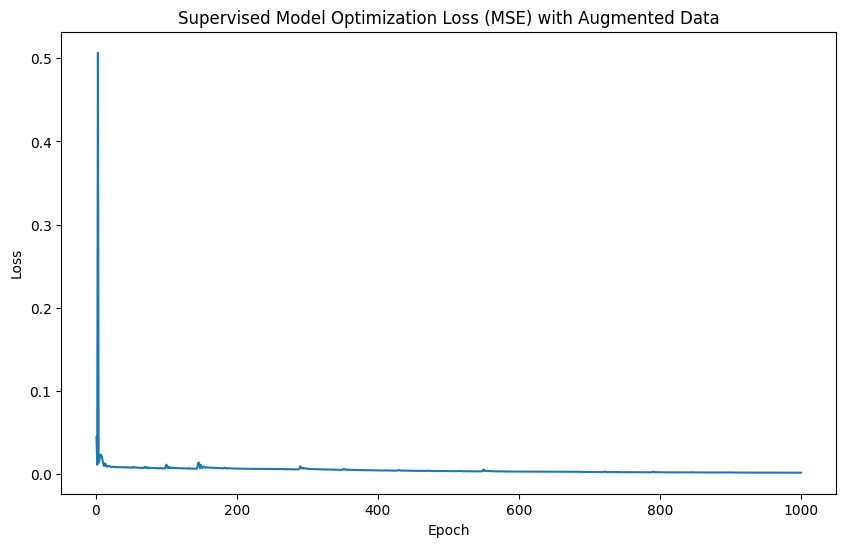

In [14]:
# Plot loss curve for supervised model with augmented data

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, eps, num=eps), supervised_model_history_augmented.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Supervised Model Optimization Loss (MSE) with Augmented Data')
plt.show()

## Evaluation

A visual comparison of the original and ground truth images with the predicted images



1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


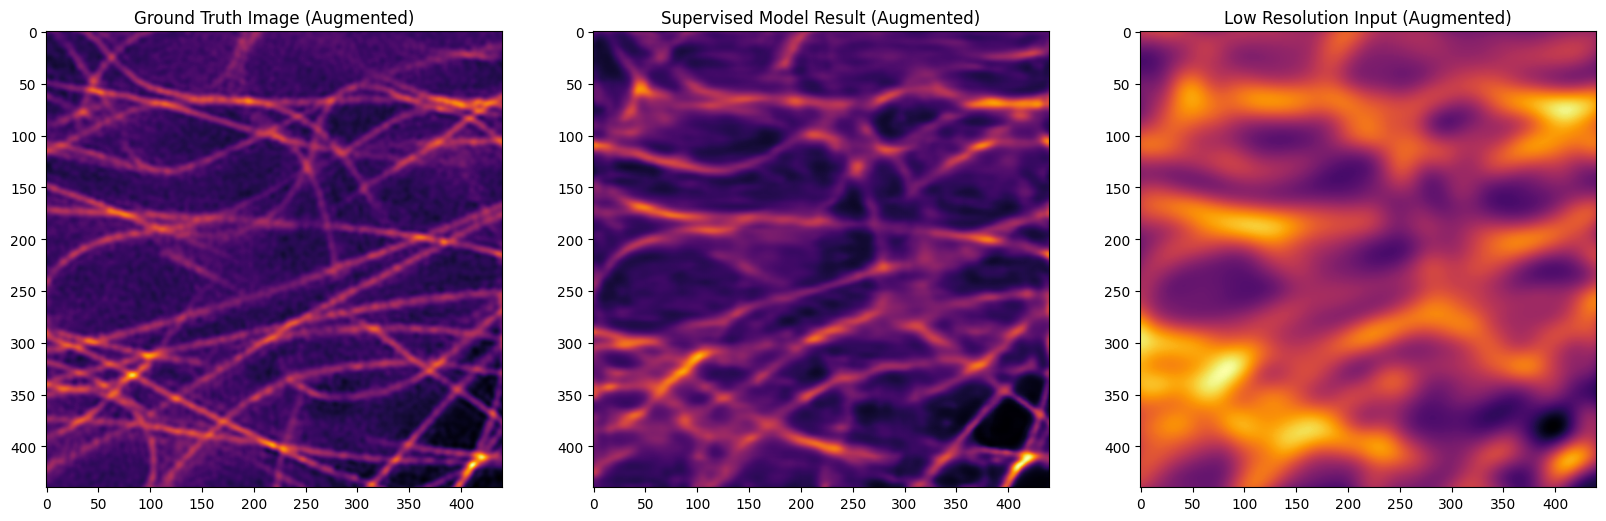

In [15]:
predicted_supervised_augmented = supervised_model.predict(x_batch_augmented)

# Select the first image from the batch for visualization
idx_to_visualize = 0

# Prepare predicted image
predicted_viz = predicted_supervised_augmented[idx_to_visualize, :, :, :].reshape([im_dim, im_dim])
predicted_viz = predicted_viz[20:(im_dim-20), 20:(im_dim-20)] # Crop
predicted_viz = (predicted_viz - np.amin(predicted_viz)) / (np.amax(predicted_viz) - np.amin(predicted_viz)) # Normalize

# Prepare ground truth image
gt_viz = y_batch_augmented[idx_to_visualize, :, :, :].reshape([im_dim, im_dim])
gt_viz = gt_viz[20:(im_dim-20), 20:(im_dim-20)] # Crop
gt_viz = (gt_viz - np.amin(gt_viz)) / (np.amax(gt_viz) - np.amin(gt_viz)) # Normalize

# Prepare low-resolution input image
lr_viz = x_batch_augmented[idx_to_visualize, :, :, :].reshape([im_dim, im_dim])
lr_viz = lr_viz[20:(im_dim-20), 20:(im_dim-20)] # Crop
lr_viz = (lr_viz - np.amin(lr_viz)) / (np.amax(lr_viz) - np.amin(lr_viz)) # Normalize

# Display images
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(gt_viz, cmap='inferno')
plt.title('Ground Truth Image (Augmented)')
plt.subplot(1,3,2)
plt.imshow(predicted_viz, cmap='inferno')
plt.title('Supervised Model Result (Augmented)')
plt.subplot(1,3,3)
plt.imshow(lr_viz, cmap='inferno')
plt.title('Low Resolution Input (Augmented)')
plt.show()